In [1]:
# Libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV

# Metrics
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_error




***IMPORT DATA***

In [2]:
# read the data
df = pd.read_csv('marketing_campaign_dataset_training_20K.csv')

# filter for only first 20,000 rows
filtered_df = df.iloc[:20000]


/var/folders/f7/dl42drj92qg78wp87m730h3m0000gn/T/ipykernel_26969/3129453109.py:2: DtypeWarning: Columns (1,2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('marketing_campaign_dataset_training_20K.csv')


***INITIAL DATA EXPLORATION***

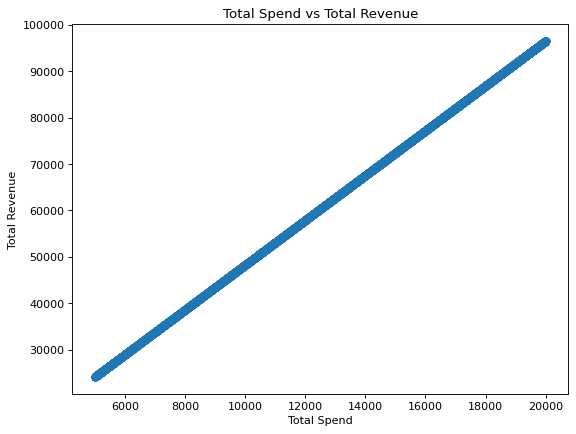

In [3]:
# plot total spend vs total revenue

figure(figsize=(8, 6), dpi=80)

plt.scatter(filtered_df['spend_total'], filtered_df['revenue_total'])
plt.title('Total Spend vs Total Revenue')
plt.xlabel('Total Spend')
plt.ylabel('Total Revenue')
plt.show()


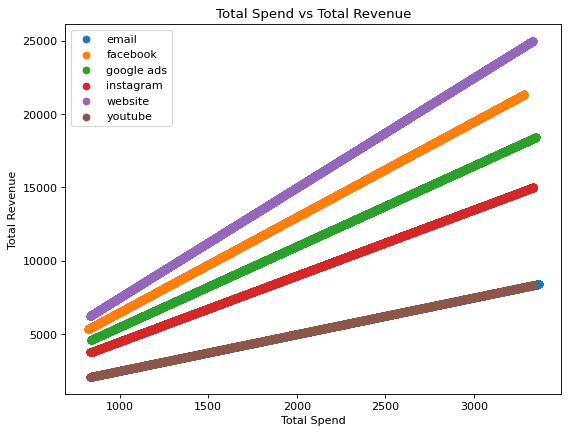

In [4]:
# Plot total spend vs total revenue for each channel

figure(figsize=(8, 6), dpi=80)

plt.scatter(filtered_df['spend_email'], filtered_df['revenue_email'], label='email')
plt.scatter(filtered_df['spend_facebook'], filtered_df['revenue_facebook'], label='facebook')
plt.scatter(filtered_df['spend_google_ads'], filtered_df['revenue_google_ads'], label='google ads')
plt.scatter(filtered_df['spend_instagram'], filtered_df['revenue_instagram'], label='instagram')
plt.scatter(filtered_df['spend_website'], filtered_df['revenue_website'], label='website')
plt.scatter(filtered_df['spend_youtube'], filtered_df['revenue_youtube'], label='youtube')
plt.title('Total Spend vs Total Revenue')
plt.xlabel('Total Spend')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()


***DATA PRE-PROCESSING***

In [5]:
# define dependent variables

y = filtered_df[['revenue_email', 'revenue_facebook', 'revenue_google_ads', 'revenue_instagram', 
        'revenue_website', 'revenue_youtube']]

In [6]:
# define the features (independent variables) as X
X = filtered_df.drop(['revenue_email', 'revenue_facebook', 'revenue_google_ads', 'revenue_instagram', 
        'revenue_website', 'revenue_youtube', 'revenue_total','impressions','clicks','id','name', 'spend_total', 'end_date'], axis=1)

X

,start_date,duration,customer_segment,target_audience,spend_email,spend_facebook,spend_google_ads,spend_instagram,spend_website,spend_youtube
0,1/1/2023,30.0,Health & Wellness,Men 18-24,2722.0,2655.0,2709.0,2698.0,2694.0,2695.0
1,1/2/2023,60.0,Fashionistas,Women 35-44,1946.0,1899.0,1937.0,1929.0,1927.0,1928.0
2,1/3/2023,30.0,Outdoor Adventurers,Men 25-34,1717.0,1675.0,1709.0,1701.0,1699.0,1700.0
3,1/4/2023,60.0,Health & Wellness,All Ages,2141.0,2089.0,2131.0,2122.0,2120.0,2120.0
4,1/5/2023,15.0,Health & Wellness,Men 25-34,2769.0,2701.0,2756.0,2744.0,2741.0,2742.0
...,...,...,...,...,...,...,...,...,...,...
19995,10/13/2023,30.0,Health & Wellness,Men 18-24,1567.0,1529.0,1560.0,1553.0,1551.0,1552.0
19996,10/14/2023,15.0,Health & Wellness,Men 18-24,992.0,968.0,987.0,983.0,982.0,982.0
19997,10/15/2023,45.0,Foodies,Women 35-44,1867.0,1822.0,1858.0,1851.0,1848.0,1849.0
19998,10/16/2023,60.0,Foodies,Men 25-34,2393.0,2335.0,2382.0,2372.0,2369.0,2370.0


In [7]:
# # Convert Acquisition_Cost column from $ to float
# filtered_df['Acquisition_Cost'] = filtered_df['Acquisition_Cost'].str.replace('$', '').str.replace(',', '').astype(float)
# # Split the string on space and take the first part (the number), then convert to integer
# filtered_df['Duration'] = filtered_df['Duration'].str.split().str[0].astype(int)

In [8]:
# Handle missing values with mean imputation for numerical variables and mode imputation for categorical variables

# for col in X.columns:
#     if X[col].dtype == 'object':
#         X[col].fillna(X[col].mode()[0], inplace=True)
#     else:
#         X[col].fillna(X[col].mean(), inplace=True)

In [9]:
# convert date column to datetime format

X['start_date'] = pd.to_datetime(X['start_date'])
X['year'] = X['start_date'].dt.year
X['month'] = X['start_date'].dt.month
X['day'] = X['start_date'].dt.day

# Drop the original date column
X = X.drop('start_date', axis=1)

# convert categorical variables to dummy variables
X = pd.get_dummies(X)

X

,duration,spend_email,spend_facebook,spend_google_ads,spend_instagram,spend_website,spend_youtube,year,month,day,customer_segment_Fashionistas,customer_segment_Foodies,customer_segment_Health & Wellness,customer_segment_Outdoor Adventurers,customer_segment_Tech Enthusiasts,target_audience_All Ages,target_audience_Men 18-24,target_audience_Men 25-34,target_audience_Women 25-34,target_audience_Women 35-44
0,30.0,2722.0,2655.0,2709.0,2698.0,2694.0,2695.0,2023,1,1,False,False,True,False,False,False,True,False,False,False
1,60.0,1946.0,1899.0,1937.0,1929.0,1927.0,1928.0,2023,1,2,True,False,False,False,False,False,False,False,False,True
2,30.0,1717.0,1675.0,1709.0,1701.0,1699.0,1700.0,2023,1,3,False,False,False,True,False,False,False,True,False,False
3,60.0,2141.0,2089.0,2131.0,2122.0,2120.0,2120.0,2023,1,4,False,False,True,False,False,True,False,False,False,False
4,15.0,2769.0,2701.0,2756.0,2744.0,2741.0,2742.0,2023,1,5,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,30.0,1567.0,1529.0,1560.0,1553.0,1551.0,1552.0,2023,10,13,False,False,True,False,False,False,True,False,False,False
19996,15.0,992.0,968.0,987.0,983.0,982.0,982.0,2023,10,14,False,False,True,False,False,False,True,False,False,False
19997,45.0,1867.0,1822.0,1858.0,1851.0,1848.0,1849.0,2023,10,15,False,True,False,False,False,False,False,False,False,True
19998,60.0,2393.0,2335.0,2382.0,2372.0,2369.0,2370.0,2023,10,16,False,True,False,False,False,False,False,True,False,False


***SPLIT DATA***

In [10]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


***SETUP TRAINING CONDITIONS AND INSTANTIATE MODELS***

In [11]:
# Instaniate K Fold cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create params space for RandomizedSearchCV to search over for RandomForestRegressor

params_random_forest = {
    'estimator__n_estimators': [100, 200, 300, 400, 500],
    'estimator__max_depth': [None, 1, 2, 3, 4, 5],
    'estimator__min_samples_split': [2, 3, 4, 5],
    'estimator__min_samples_leaf': [1, 2, 3, 4, 5],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}


# Create params space for RandomizedSearchCV to search over for Lasso and Ridge models

params_lasso = {
    'estimator__alpha': [0.01, 0.1, 1, 10, 100, 1000]
}

params_ridge = {
    'estimator__alpha': [0.01, 0.1, 1, 10, 100, 1000],
    'estimator__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}




In [12]:
# Instantiate the RandomizedSearchCV objects for all models with multiple output regression
random_forecast_cv = RandomizedSearchCV(MultiOutputRegressor(RandomForestRegressor()), params_random_forest, cv=kf, n_iter=10, n_jobs=-1, verbose=1)
lasso_cv = RandomizedSearchCV(MultiOutputRegressor(Lasso()), params_lasso, cv=kf, n_iter=10, n_jobs=-1, verbose=1)
ridge_cv = RandomizedSearchCV(MultiOutputRegressor(Ridge()), params_ridge, cv=kf, n_iter=10, n_jobs=-1, verbose=1)

# Instantiate Linear Regression model
linear_regression = MultiOutputRegressor(LinearRegression())


***FIT MODELS***

In [13]:
# Fit Random Forest, Lasso, and Ridge models on training data

random_forecast_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/justinchung/Coding/Springboard_Bootcamp/capstone_2/marketing_planner_app/backend/venvcapstone2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/justinchung/Coding/Springboard_Bootcamp/capstone_2/marketing_planner_app/backend/venvcapstone2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/justinchung/Coding/Springboard_Bootcamp/capstone_2/marketing_planner_app/backend/venvcapstone2/lib/python3.10/site-packa

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=MultiOutputRegressor(estimator=Ridge()), n_jobs=-1,
                   param_distributions={'estimator__alpha': [0.01, 0.1, 1, 10,
                                                             100, 1000],
                                        'estimator__solver': ['auto', 'svd',
                                                              'cholesky',
                                                              'lsqr',
                                                              'sparse_cg',
                                                              'sag', 'saga']},
                   verbose=1)

***MEASURE MODEL PERFORMANCE***

***MAKE PREDICTIONS***

In [14]:
# Make predictions on test data

random_forecast_cv_pred = random_forecast_cv.predict(X_test)
lasso_cv_pred = lasso_cv.predict(X_test)
ridge_cv_pred = ridge_cv.predict(X_test)
linear_regression_pred = linear_regression.fit(X_train, y_train).predict(X_test)


***MEASURE MODEL PERFORMANCE***

In [15]:
# Print the tuned parameters and score for the best model for each model

print('********************** Linear Regression R2 Score **********************')
print("Liner Regression Cross Validated Score: {}".format(cross_val_score(linear_regression, X_train, y_train, cv=kf).mean()))  

print('********************** Random Forest Best Params & R2 Score **********************')
print("Tuned Random Forest Parameters: {}".format(random_forecast_cv.best_params_))
print("Tuned Random Forest Best Accuracy Score: {}".format(random_forecast_cv.best_score_))

print('********************** Lasso Best Params & R2 Score **********************')
print("Tuned Lasso Parameters: {}".format(lasso_cv.best_params_))
print("Tuned Lasso Best Accuracy Score: {}".format(lasso_cv.best_score_))

print('********************** Ridge Best Params & R2 Score **********************')
print("Tuned Ridge Parameters: {}".format(ridge_cv.best_params_))
print("Tuned Ridge Best Accuracy Score: {}".format(ridge_cv.best_score_))

********************** Linear Regression R2 Score **********************
Liner Regression Cross Validated Score: 0.999999960971053
********************** Random Forest Best Params & R2 Score **********************
Tuned Random Forest Parameters: {'estimator__n_estimators': 100, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 5, 'estimator__max_features': 'sqrt', 'estimator__max_depth': None}
Tuned Random Forest Best Accuracy Score: 0.9999971839068147
********************** Lasso Best Params & R2 Score **********************
Tuned Lasso Parameters: {'estimator__alpha': 1}
Tuned Lasso Best Accuracy Score: 0.9999998317582943
********************** Ridge Best Params & R2 Score **********************
Tuned Ridge Parameters: {'estimator__solver': 'auto', 'estimator__alpha': 100}
Tuned Ridge Best Accuracy Score: 0.9999999609744762


In [16]:
# Measure the performance of the models with the test data

# R2 score is the proportion of the variance in the dependent variable that is predictable from the independent variable(s)

print('****************** R2 Score ******************')
print('Linear Regression R2:', linear_regression.score(X_test, y_test))
print('Random Forest R2:', random_forecast_cv.score(X_test, y_test))
print('Lasso R2:', lasso_cv.score(X_test, y_test))
print('Ridge R2:', ridge_cv.score(X_test, y_test))


# Mean Squared Error (MSE) is the mean of the squared errors. It’s more popular than MAE because MSE "punishes" larger errors, which tends to be useful in the real world.
print('****************** MSE ******************')
print('Linear Regression MSE:', mean_squared_error(y_test, linear_regression_pred))
print('Random Forest MSE:', mean_squared_error(y_test, random_forecast_cv_pred))
print('Lasso MSE:', mean_squared_error(y_test, lasso_cv_pred))
print('Ridge MSE:', mean_squared_error(y_test, ridge_cv_pred))


# # Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
print('****************** RMSE ******************')
print('Linear Regression RMSE:', mean_squared_error(y_test, linear_regression_pred, squared=False))
print('Random Forest RMSE:', mean_squared_error(y_test, random_forecast_cv_pred, squared=False))
print('Lasso RMSE:', mean_squared_error(y_test, lasso_cv_pred, squared=False))
print('Ridge RMSE:', mean_squared_error(y_test, ridge_cv_pred, squared=False))





****************** R2 Score ******************
Linear Regression R2: 0.9999999619965609
Random Forest R2: 0.9999979002908956
Lasso R2: 0.9999998305896013
Ridge R2: 0.9999999619997461
****************** MSE ******************
Linear Regression MSE: 0.44852473850806307
Random Forest MSE: 25.959890827372103
Lasso MSE: 2.2840912563203624
Ridge MSE: 0.4484813620006765
****************** RMSE ******************
Linear Regression RMSE: 0.6430586494188227
Random Forest RMSE: 4.858347119276416
Lasso RMSE: 1.4199534069913662
Ridge RMSE: 0.643028678723398


***VISUALIZE COEFFICIENTS AND FEATURE IMPORTANCE***

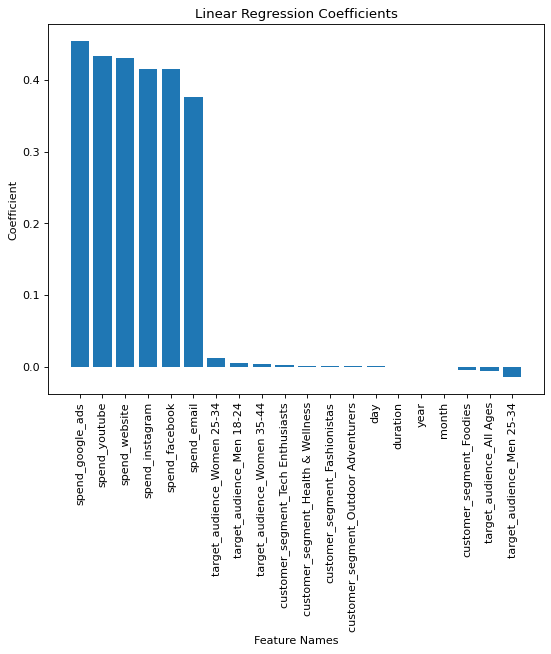

In [17]:
# Graph Coefficients from Linear Regression Models

# Get coefficients from linear regression model
linear_regression_coef = linear_regression.estimators_[0].coef_

# Get feature names from X_train
feature_names = X_train.columns

# Create a dataframe of coefficients and their feature names
linear_regression_coef_df = pd.DataFrame({'feature_names': feature_names, 'coef': linear_regression_coef})

# Sort the dataframe by coefficient value
linear_regression_coef_df = linear_regression_coef_df.sort_values('coef', ascending=False)

# Plot the coefficients
figure(figsize=(8, 6), dpi=80)
plt.bar(linear_regression_coef_df['feature_names'], linear_regression_coef_df['coef'])
plt.xticks(rotation=90)
plt.title('Linear Regression Coefficients')
plt.xlabel('Feature Names')
plt.ylabel('Coefficient')
plt.show()





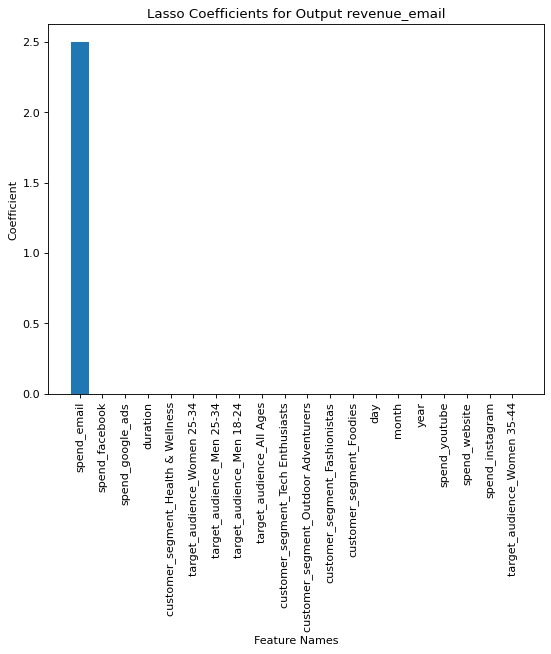

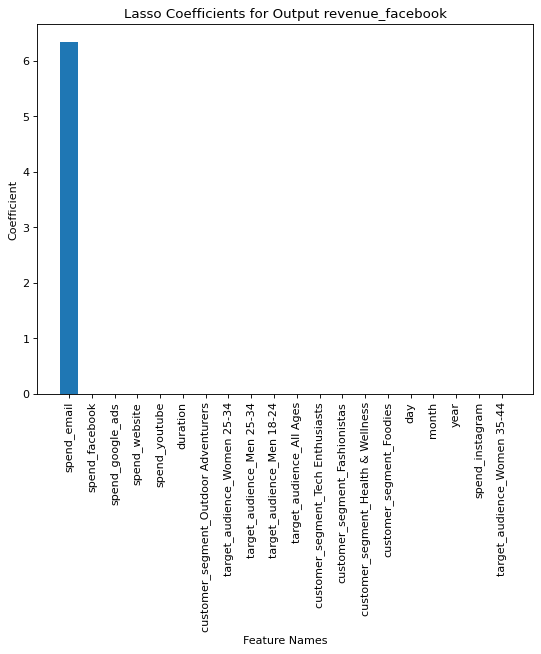

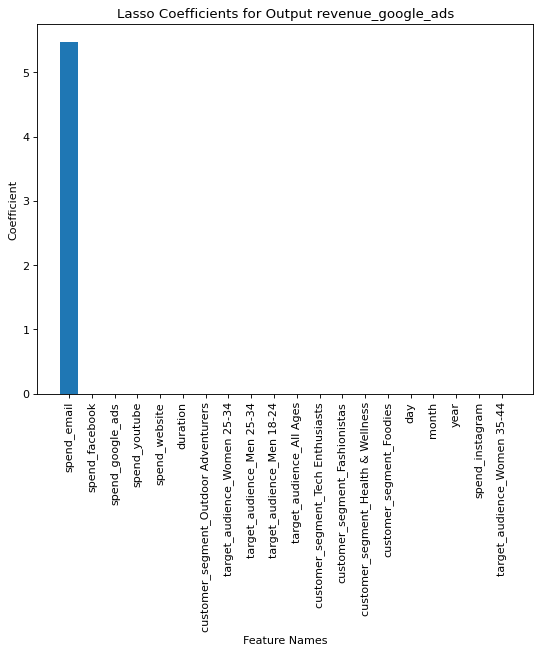

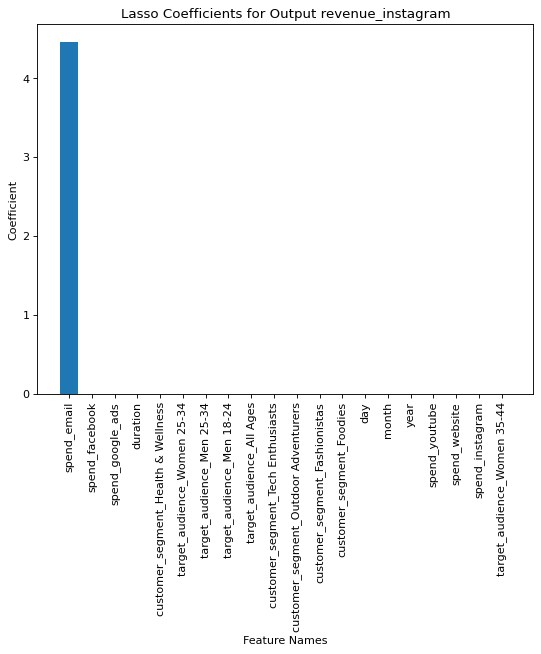

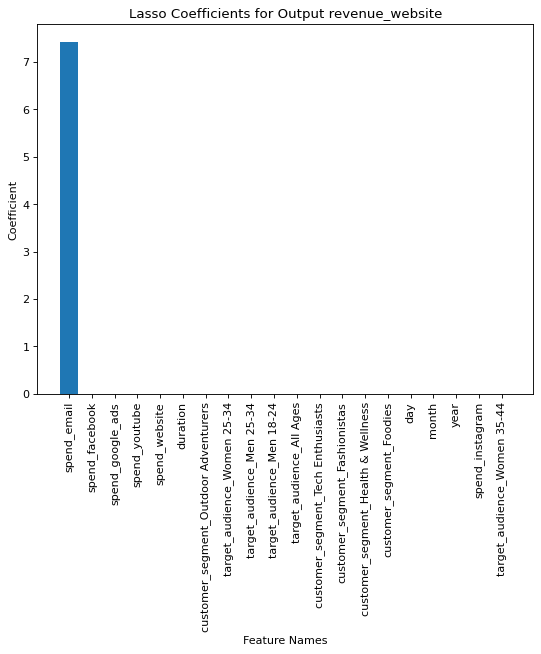

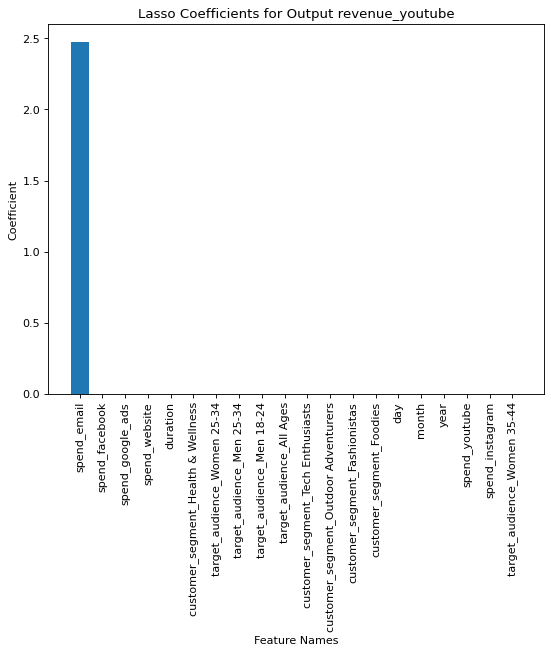

In [18]:
# Graph Coefficients from Lasso Models

# Assuming X_train is your training data
feature_names = X_train.columns

# Access the best multi-output estimator
best_lasso = lasso_cv.best_estimator_

# Dependet variable names
dependent_variables = y.columns

# Loop through each estimator to get coefficients
for i, estimator in enumerate(best_lasso.estimators_):
    lasso_coef = estimator.coef_
    lasso_coef_df = pd.DataFrame({'feature_names': feature_names, 'coef': lasso_coef})
    lasso_coef_df = lasso_coef_df.sort_values('coef', ascending=False)

    # Plot the coefficients for each output
    figure(figsize=(8, 6), dpi=80)
    plt.bar(lasso_coef_df['feature_names'], lasso_coef_df['coef'])
    plt.xticks(rotation=90)
    plt.title(f'Lasso Coefficients for Output {dependent_variables[i]}')
    plt.xlabel('Feature Names')
    plt.ylabel('Coefficient')
    plt.show()


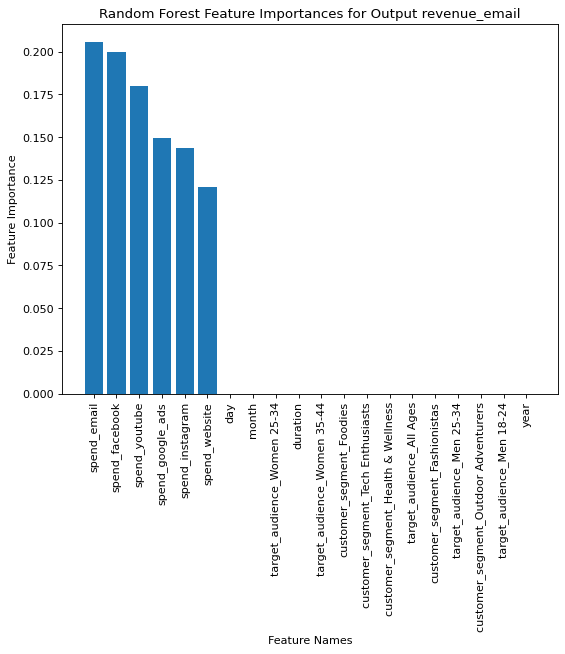

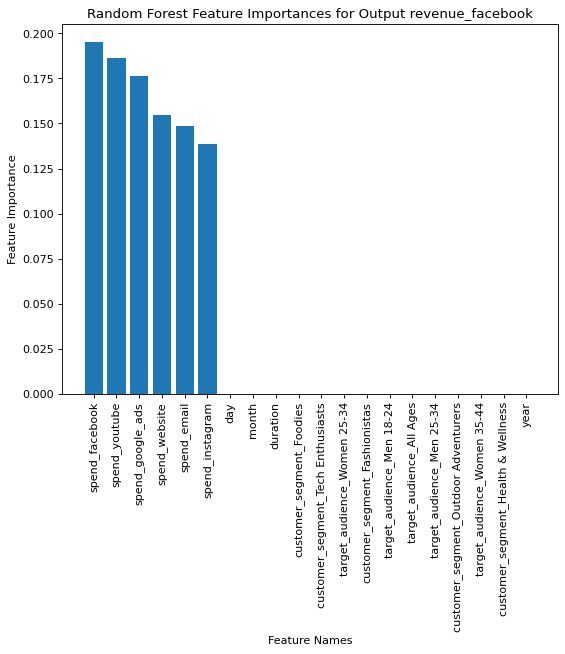

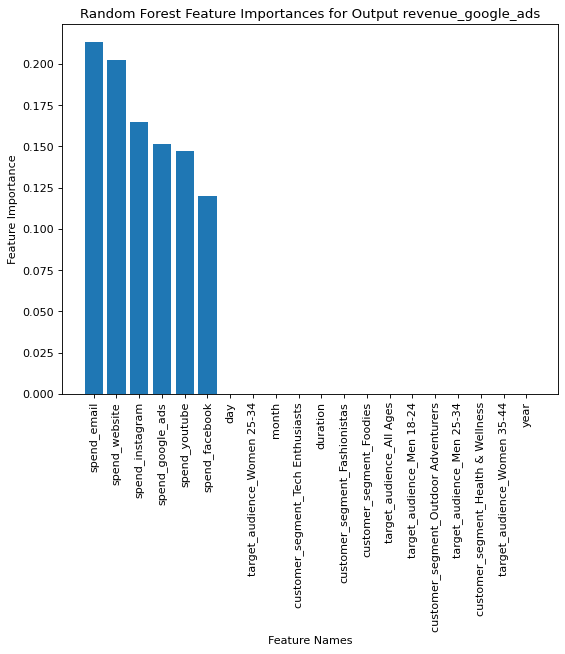

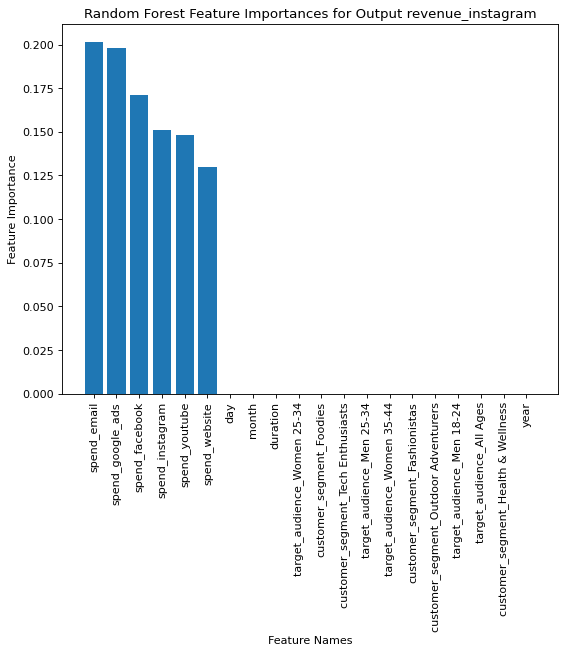

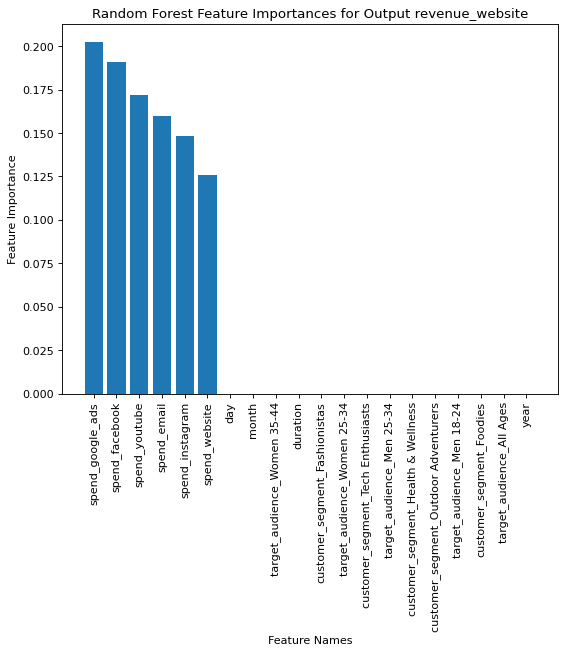

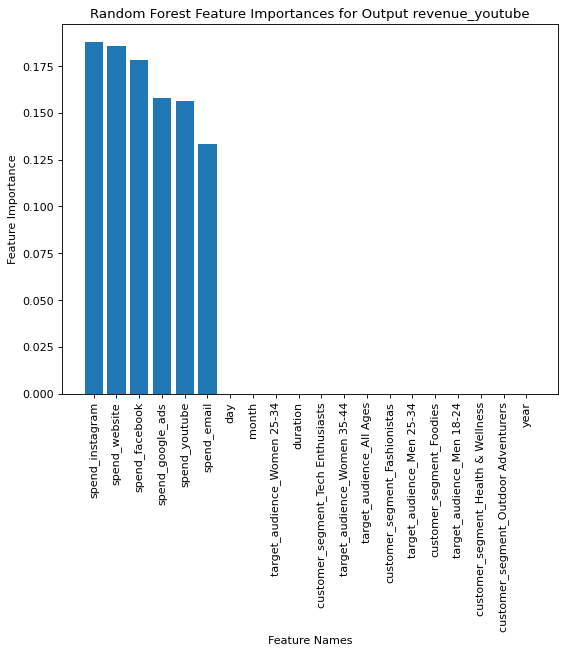

In [19]:
# Graph Feature Importances from Random Forest Models

# Assuming X_train is your training data
feature_names = X_train.columns

# Access the best multi-output estimator
best_random_forest = random_forecast_cv.best_estimator_

# Dependet variable names
dependent_variables = y.columns

# Loop through each estimator to get feature importances
for i, estimator in enumerate(best_random_forest.estimators_):
    random_forest_feature_importances = estimator.feature_importances_
    random_forest_feature_importances_df = pd.DataFrame({'feature_names': feature_names, 'feature_importances': random_forest_feature_importances})
    random_forest_feature_importances_df = random_forest_feature_importances_df.sort_values('feature_importances', ascending=False)

    # Plot the feature importances for each output
    figure(figsize=(8, 6), dpi=80)
    plt.bar(random_forest_feature_importances_df['feature_names'], random_forest_feature_importances_df['feature_importances'])
    plt.xticks(rotation=90)
    plt.title(f'Random Forest Feature Importances for Output {dependent_variables[i]}')
    plt.xlabel('Feature Names')
    plt.ylabel('Feature Importance')
    plt.show()

***SAVE MODELS TO DISK***

In [20]:
#Save the models to disk

rf_filename = 'marketing_planner_random_forest_model.sav'
lr_filename = 'marketing_planner_linear_regression_model.sav'
lasso_filename = 'marketing_planner_lasso_model.sav'
ridge_filename = 'marketing_planner_ridge_model.sav'

pickle.dump(random_forecast_cv, open(rf_filename, 'wb'))
pickle.dump(linear_regression, open(lr_filename, 'wb'))
pickle.dump(lasso_cv, open(lasso_filename, 'wb'))
pickle.dump(ridge_cv, open(ridge_filename, 'wb'))

